# Bài toán 1: Dự đoán Giá Nhà sử dụng Machine Learning

## Mục tiêu
Xây dựng mô hình Machine Learning để dự đoán giá nhà dựa trên các đặc điểm như diện tích, số phòng, vị trí địa lý, và các yếu tố khác.

## Dataset
- File: `data/complete_house_dataset.csv`
- Số lượng: ~118,000 records
- Features: 28 cột bao gồm price, area, rooms, toilets, floors, location, etc.

## Workflow
1. Import thư viện và load data
2. Exploratory Data Analysis (EDA)
3. Data Preprocessing & Feature Engineering
4. Model Training (Linear Regression, Random Forest, XGBoost)
5. Model Evaluation & Comparison
6. Feature Importance Analysis
7. Save Model để deploy

---

## 1. Import Libraries

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Gradient Boosting Libraries
import xgboost as xgb
import lightgbm as lgb

# Model persistence
import joblib
from datetime import datetime
import time

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")

✅ All libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 2.1.3
XGBoost version: 3.0.4
LightGBM version: 4.6.0


## 2. Load Dataset và Khám phá ban đầu

In [2]:
# Load dataset (sử dụng cleaned data nếu có, nếu không thì dùng original)
import os

cleaned_file = 'data/cleaned_house_dataset.csv'
original_file = 'data/complete_house_dataset.csv'

if os.path.exists(cleaned_file):
    print(f"✅ Đang load cleaned data: {cleaned_file}")
    df = pd.read_csv(cleaned_file)
    print("   → Dữ liệu đã được làm sạch trước đó, bỏ qua bước cleaning\n")
else:
    print(f"⚠️  Cleaned data chưa có, đang load original data: {original_file}")
    df = pd.read_csv(original_file)
    print("   → Cần chạy bước cleaning ở cell tiếp theo\n")

# Thông tin cơ bản
print("="*80)
print("THÔNG TIN DATASET")
print("="*80)
print(f"📊 Số dòng: {df.shape[0]:,}")
print(f"📊 Số cột: {df.shape[1]}")
print(f"💾 Kích thước: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "="*80)
print("5 DÒNG ĐẦU TIÊN")
print("="*80)
df.head()

✅ Đang load cleaned data: data/cleaned_house_dataset.csv
   → Dữ liệu đã được làm sạch trước đó, bỏ qua bước cleaning

THÔNG TIN DATASET
📊 Số dòng: 10,044
📊 Số cột: 28
💾 Kích thước: 22.81 MB

5 DÒNG ĐẦU TIÊN


,id,title,price,area,date,city,district,ward,street,lat,lng,body,rooms,toilets,floors,legal,seller_type,protection,image_count,image_thumb,width,length,pty_characteristics,owner_type,is_pro,verified,page,dateFormatted
0,172448163,BÁN NHÀ NGỌC THUỴ 5 TẦNG XÂY ĐẸP - NGÕ Ô TÔ ĐỖ...,7500000000,40.0,1766120565000,Hà Nội,Quận Long Biên,Phường Ngọc Thụy,Đường Ngọc Thụy,21.059816,105.863655,"- diện tích 40m2 \r\n- Bán nhà 5 tầng, full nộ...",3.0,4.0,5.0,1.0,True,False,8,https://cdn.chotot.com/eyVUiVEYyKCf7vUjZ-0tHD9...,NaN,NaN,"[2, 3]",True,True,False,0,2025-12-19
1,171753972,"7,78tỷ, 123m2, 3PN CĂN GÓC CC PACKEXIM Võ Chí ...",7850000000,123.0,1766120335000,Hà Nội,Quận Tây Hồ,Phường Phú Thượng,An Dương Vương,21.087900,105.814640,Cần Bán gấp căn hộ chung cư PACKEXIM Tây Hồ ch...,3.0,2.0,NaN,6.0,False,False,6,https://cdn.chotot.com/_dNyy_yK4IgDsdQNJ6RYSRU...,NaN,NaN,[],NaN,False,False,0,2025-12-19
2,173047043,NHÀ BIÊN GIANG HÀ ĐÔNG - 38M2 X 5 TẦNG - Ô TÔ ...,5200000000,38.0,1766120222000,Hà Nội,Quận Hà Đông,Phường Biên Giang,Quốc Lộ 6,20.928316,105.721920,NHÀ BIÊN GIANG HÀ ĐÔNG - 38M2 X 5 TẦNG - Ô TÔ ...,3.0,NaN,NaN,1.0,True,False,12,https://cdn.chotot.com/D2-PV3NvYtwqX9s0TaWFNlq...,NaN,NaN,[],True,True,False,0,2025-12-19
3,173047018,BÁN NHÀ NGÕ 141 NAM DƯ – LĨNH NAM | DÒNG TIỀN ...,9200000000,46.0,1766120209000,Hà Nội,Quận Hoàng Mai,Phường Lĩnh Nam,Phố Nam Dư,20.985332,105.888290,BÁN NHÀ NGÕ 141 NAM DƯ – LĨNH NAM | DÒNG TIỀN ...,7.0,6.0,5.0,1.0,False,False,12,https://cdn.chotot.com/EfgTJ3Ven-Hth37N72joEgw...,5.0,9.5,[2],NaN,False,False,0,2025-12-19
4,172448699,"BÁN GẤP NHÀ ĐẸP HOA LÂM - Ô TÔ ĐỖ CỬA , VÀI BƯ...",6000000000,33.0,1766119664000,Hà Nội,Quận Long Biên,Phường Đức Giang,hoa lâm,21.059334,105.894620,hiện tại do công tác nơi xa nên chủ nhà thiện ...,3.0,4.0,5.0,1.0,True,False,11,https://cdn.chotot.com/GmW4V4YludkDiXxX9CK7QcL...,NaN,NaN,[],True,True,False,0,2025-12-19


## 3. Quick EDA (Optional - skip nếu dùng cleaned data)

THỐNG KÊ GIÁ NHÀ
Count:  10,044
Mean:   5.54 tỷ
Median: 5.60 tỷ
Std:    2.02 tỷ
Min:    1.29 tỷ
Max:    9.20 tỷ


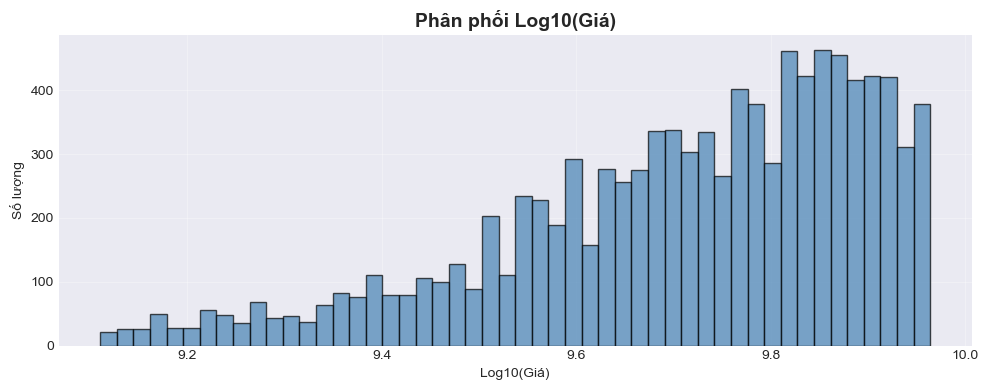

In [3]:
# Quick EDA: Phân phối giá và thống kê cơ bản (OPTIONAL - chỉ chạy nếu muốn xem data)
print("="*80)
print("THỐNG KÊ GIÁ NHÀ")
print("="*80)
price_stats = df['price'].describe()
print(f"Count:  {price_stats['count']:,.0f}")
print(f"Mean:   {price_stats['mean']/1e9:.2f} tỷ")
print(f"Median: {price_stats['50%']/1e9:.2f} tỷ")
print(f"Std:    {price_stats['std']/1e9:.2f} tỷ")
print(f"Min:    {price_stats['min']/1e9:.2f} tỷ")
print(f"Max:    {price_stats['max']/1e9:.2f} tỷ")

# Histogram nhanh
plt.figure(figsize=(10, 4))
plt.hist(np.log10(df['price'][df['price'] > 0]), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.title('Phân phối Log10(Giá)', fontsize=14, fontweight='bold')
plt.xlabel('Log10(Giá)')
plt.ylabel('Số lượng')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Data Cleaning (Chỉ chạy nếu chưa có cleaned data)

In [4]:
# Feature Engineering - Sử dụng df (vì đã là cleaned data)
df_clean = df.copy()

print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Tạo các features mới
if 'rooms' in df_clean.columns and 'toilets' in df_clean.columns:
    df_clean['total_rooms'] = df_clean['rooms'].fillna(0) + df_clean['toilets'].fillna(0)
    df_clean['toilet_room_ratio'] = df_clean['toilets'] / (df_clean['rooms'] + 1)
    print("✅ total_rooms, toilet_room_ratio")

if 'area' in df_clean.columns and 'floors' in df_clean.columns:
    df_clean['area_per_floor'] = df_clean['area'] / (df_clean['floors'].fillna(1) + 0.1)
    df_clean['total_floor_area'] = df_clean['area'] * df_clean['floors'].fillna(1)
    print("✅ area_per_floor, total_floor_area")

if 'width' in df_clean.columns and 'length' in df_clean.columns:
    df_clean['has_dimensions'] = ((df_clean['width'].notna()) & (df_clean['length'].notna())).astype(int)
    df_clean['width_length_ratio'] = df_clean['width'] / (df_clean['length'] + 0.1)
    print("✅ has_dimensions, width_length_ratio")

if 'lat' in df_clean.columns and 'lng' in df_clean.columns:
    center_lat, center_lng = 21.0285, 105.8542
    df_clean['distance_from_center'] = np.sqrt(
        (df_clean['lat'].fillna(center_lat) - center_lat)**2 + 
        (df_clean['lng'].fillna(center_lng) - center_lng)**2
    )
    print("✅ distance_from_center")

if 'total_rooms' in df_clean.columns and 'area' in df_clean.columns:
    df_clean['rooms_per_sqm'] = df_clean['total_rooms'] / (df_clean['area'] + 1)
    print("✅ rooms_per_sqm")

print(f"\n📊 Total features: {df_clean.shape[1]}")

FEATURE ENGINEERING
✅ total_rooms, toilet_room_ratio
✅ area_per_floor, total_floor_area
✅ has_dimensions, width_length_ratio
✅ distance_from_center
✅ rooms_per_sqm

📊 Total features: 36


In [5]:
# Chọn features cho model
print("\n" + "="*80)
print("BƯỚC 3: CHỌN FEATURES CHO MODEL")
print("="*80)

# Features số
numeric_features = [
    'area', 'rooms', 'toilets', 'floors', 'lat', 'lng',
    'width', 'length',
    'total_rooms', 'toilet_room_ratio', 'area_per_floor', 
    'has_dimensions', 'distance_from_center', 'width_length_ratio',
    'total_floor_area', 'rooms_per_sqm'
]

# Features phân loại
categorical_features = [
    'district', 'ward', 'legal', 'seller_type', 'owner_type', 'city', 'street', 'protection'
]

# Lọc các features thực sự tồn tại trong df
numeric_features = [f for f in numeric_features if f in df_clean.columns and f != 'price']
categorical_features = [f for f in categorical_features if f in df_clean.columns]

print(f"📊 Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"📊 Categorical features ({len(categorical_features)}): {categorical_features}")

# Xử lý missing values cho numeric features
for col in numeric_features:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"   → Đã fill {col} bằng median: {median_val:.2f}")

print("\n✅ Đã xử lý missing values cho numeric features")
print(f"\n⚠️  Đã BỎ price_per_sqm để tránh data leakage!")


BƯỚC 3: CHỌN FEATURES CHO MODEL
📊 Numeric features (16): ['area', 'rooms', 'toilets', 'floors', 'lat', 'lng', 'width', 'length', 'total_rooms', 'toilet_room_ratio', 'area_per_floor', 'has_dimensions', 'distance_from_center', 'width_length_ratio', 'total_floor_area', 'rooms_per_sqm']
📊 Categorical features (8): ['district', 'ward', 'legal', 'seller_type', 'owner_type', 'city', 'street', 'protection']
   → Đã fill rooms bằng median: 3.00
   → Đã fill toilets bằng median: 3.00
   → Đã fill floors bằng median: 3.00
   → Đã fill width bằng median: 4.00
   → Đã fill length bằng median: 13.00
   → Đã fill toilet_room_ratio bằng median: 0.67
   → Đã fill width_length_ratio bằng median: 0.32

✅ Đã xử lý missing values cho numeric features

⚠️  Đã BỎ price_per_sqm để tránh data leakage!


In [6]:
# Encode categorical features
print("\n" + "="*80)
print("BƯỚC 4: ENCODE CATEGORICAL FEATURES")
print("="*80)

label_encoders = {}

for col in categorical_features:
    if col in df_clean.columns:
        # Fill missing values với 'Unknown'
        df_clean[col] = df_clean[col].fillna('Unknown')
        
        # Label encoding
        le = LabelEncoder()
        df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
        label_encoders[col] = le
        
        print(f"Encoded {col}: {len(le.classes_)} unique values")

# Update numeric features list
numeric_features_final = numeric_features + [col + '_encoded' for col in categorical_features if col in df_clean.columns]

print(f"\nTotal features for model: {len(numeric_features_final)}")


BƯỚC 4: ENCODE CATEGORICAL FEATURES
Encoded district: 52 unique values
Encoded ward: 482 unique values
Encoded legal: 7 unique values
Encoded seller_type: 2 unique values
Encoded owner_type: 2 unique values
Encoded city: 2 unique values
Encoded street: 3079 unique values
Encoded protection: 2 unique values

Total features for model: 24


## 5. Train-Test Split & Feature Scaling

In [7]:
# Chuẩn bị dữ liệu cho model
X = df_clean[numeric_features_final].copy()
y = df_clean['price'].copy()

# Kiểm tra và xử lý inf values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)
print(f"📊 X shape: {X.shape}")
print(f"📊 y shape: {y.shape}")

# Split data (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n✅ Training set: {X_train.shape[0]:,} samples")
print(f"✅ Test set: {X_test.shape[0]:,} samples")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Features đã được scale bằng StandardScaler")

TRAIN-TEST SPLIT
📊 X shape: (10044, 24)
📊 y shape: (10044,)

✅ Training set: 8,035 samples
✅ Test set: 2,009 samples

✅ Features đã được scale bằng StandardScaler


## 6. Model Training & Evaluation

In [8]:
# Định nghĩa models với best parameters đã tìm được
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=15, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=42,
        n_jobs=-1
    ),
    'LightGBM': lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.1,
        num_leaves=70,
        subsample=1.0,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
}

print("="*80)
print("TRAINING MODELS")
print("="*80)
print(f"🚀 Sẽ train {len(models)} models với optimized parameters\n")

TRAINING MODELS
🚀 Sẽ train 6 models với optimized parameters



In [9]:
# Train và evaluate các models
results = []

for name, model in models.items():
    print(f"⏳ Training {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict on test set only (không cần train predictions)
    y_test_pred = model.predict(X_test_scaled)
    
    # Evaluate on test set
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': name,
        'Test MAE': test_mae,
        'Test RMSE': test_rmse,
        'Test R²': test_r2
    })
    
    print(f"✅ {name}: MAE={test_mae:,.0f} | RMSE={test_rmse:,.0f} | R²={test_r2:.4f}\n")

# Create results dataframe - Sort by Test MAE (thấp nhất = tốt nhất)
results_df = pd.DataFrame(results).sort_values('Test MAE', ascending=True)

print("="*80)
print("MODEL COMPARISON RESULTS (Sorted by Test MAE - Lower is Better)")
print("="*80)
print(results_df.to_string(index=False))
print(f"\n🏆 Best model (lowest test loss): {results_df.iloc[0]['Model']}")
print(f"   Best Test MAE: {results_df.iloc[0]['Test MAE']:,.0f} VNĐ ({results_df.iloc[0]['Test MAE']/1e9:.2f} tỷ)")

⏳ Training Linear Regression...
✅ Linear Regression: MAE=1,117,373,110 | RMSE=1,443,491,872 | R²=0.5009

⏳ Training Decision Tree...
✅ Decision Tree: MAE=983,683,500 | RMSE=1,406,093,956 | R²=0.5264

⏳ Training Gradient Boosting...
✅ Gradient Boosting: MAE=838,098,071 | RMSE=1,104,445,248 | R²=0.7078

⏳ Training Random Forest...
✅ Random Forest: MAE=794,263,638 | RMSE=1,073,741,743 | R²=0.7238

⏳ Training XGBoost...
✅ XGBoost: MAE=827,155,136 | RMSE=1,090,260,457 | R²=0.7153

⏳ Training LightGBM...
✅ LightGBM: MAE=800,100,024 | RMSE=1,060,610,221 | R²=0.7306

MODEL COMPARISON RESULTS (Sorted by Test MAE - Lower is Better)
            Model     Test MAE    Test RMSE  Test R²
    Random Forest 7.942636e+08 1.073742e+09 0.723847
         LightGBM 8.001000e+08 1.060610e+09 0.730560
          XGBoost 8.271551e+08 1.090260e+09 0.715284
Gradient Boosting 8.380981e+08 1.104445e+09 0.707828
    Decision Tree 9.836835e+08 1.406094e+09 0.526435
Linear Regression 1.117373e+09 1.443492e+09 0.500909

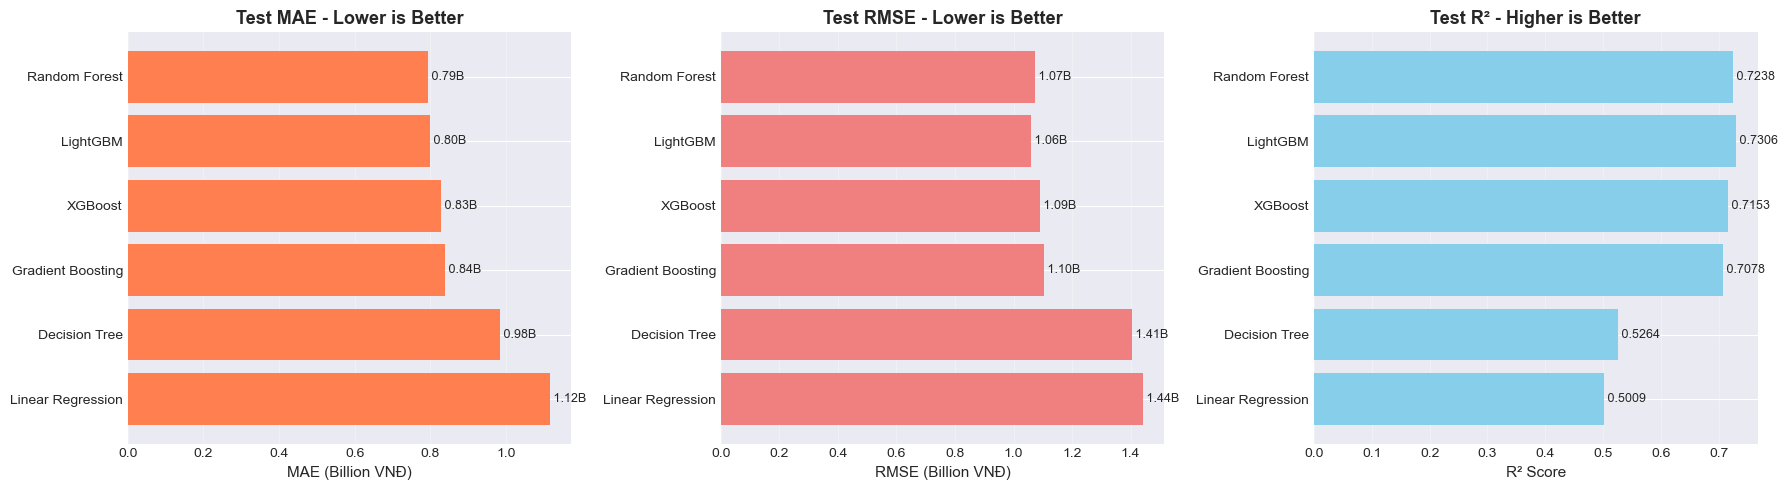

In [10]:
# Visualization: Model Comparison (Test Performance Only)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Test MAE comparison (lower is better)
axes[0].barh(results_df['Model'], results_df['Test MAE']/1e9, color='coral')
axes[0].set_xlabel('MAE (Billion VNĐ)', fontsize=11)
axes[0].set_title('Test MAE - Lower is Better', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()
for i, v in enumerate(results_df['Test MAE']/1e9):
    axes[0].text(v, i, f' {v:.2f}B', va='center', fontsize=9)

# Test RMSE comparison (lower is better)
axes[1].barh(results_df['Model'], results_df['Test RMSE']/1e9, color='lightcoral')
axes[1].set_xlabel('RMSE (Billion VNĐ)', fontsize=11)
axes[1].set_title('Test RMSE - Lower is Better', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()
for i, v in enumerate(results_df['Test RMSE']/1e9):
    axes[1].text(v, i, f' {v:.2f}B', va='center', fontsize=9)

# R² Score comparison (higher is better)
axes[2].barh(results_df['Model'], results_df['Test R²'], color='skyblue')
axes[2].set_xlabel('R² Score', fontsize=11)
axes[2].set_title('Test R² - Higher is Better', fontsize=13, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)
axes[2].invert_yaxis()
for i, v in enumerate(results_df['Test R²']):
    axes[2].text(v, i, f' {v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 7. Best Model Analysis & Feature Importance

BEST MODEL
🏆 Random Forest
   Test R²: 0.7238
   Test MAE: 794,263,638 VNĐ (0.79 tỷ)
   Test RMSE: 1,073,741,743 VNĐ (1.07 tỷ)


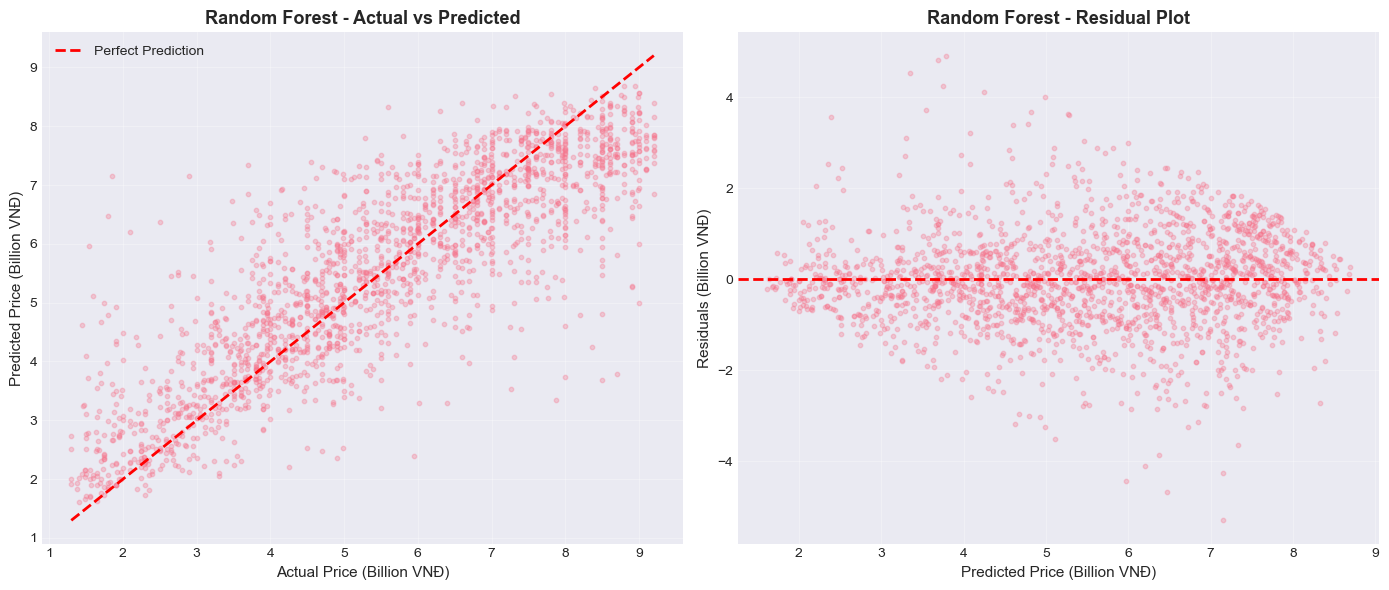

In [11]:
# Chọn best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print("="*80)
print("BEST MODEL")
print("="*80)
print(f"🏆 {best_model_name}")
print(f"   Test R²: {results_df.iloc[0]['Test R²']:.4f}")
print(f"   Test MAE: {results_df.iloc[0]['Test MAE']:,.0f} VNĐ ({results_df.iloc[0]['Test MAE']/1e9:.2f} tỷ)")
print(f"   Test RMSE: {results_df.iloc[0]['Test RMSE']:,.0f} VNĐ ({results_df.iloc[0]['Test RMSE']/1e9:.2f} tỷ)")

# Predict với best model
y_pred_best = best_model.predict(X_test_scaled)

# Actual vs Predicted
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test/1e9, y_pred_best/1e9, alpha=0.3, s=10)
plt.plot([y_test.min()/1e9, y_test.max()/1e9], 
         [y_test.min()/1e9, y_test.max()/1e9], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price (Billion VNĐ)', fontsize=11)
plt.ylabel('Predicted Price (Billion VNĐ)', fontsize=11)
plt.title(f'{best_model_name} - Actual vs Predicted', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred_best
plt.subplot(1, 2, 2)
plt.scatter(y_pred_best/1e9, residuals/1e9, alpha=0.3, s=10)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price (Billion VNĐ)', fontsize=11)
plt.ylabel('Residuals (Billion VNĐ)', fontsize=11)
plt.title(f'{best_model_name} - Residual Plot', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

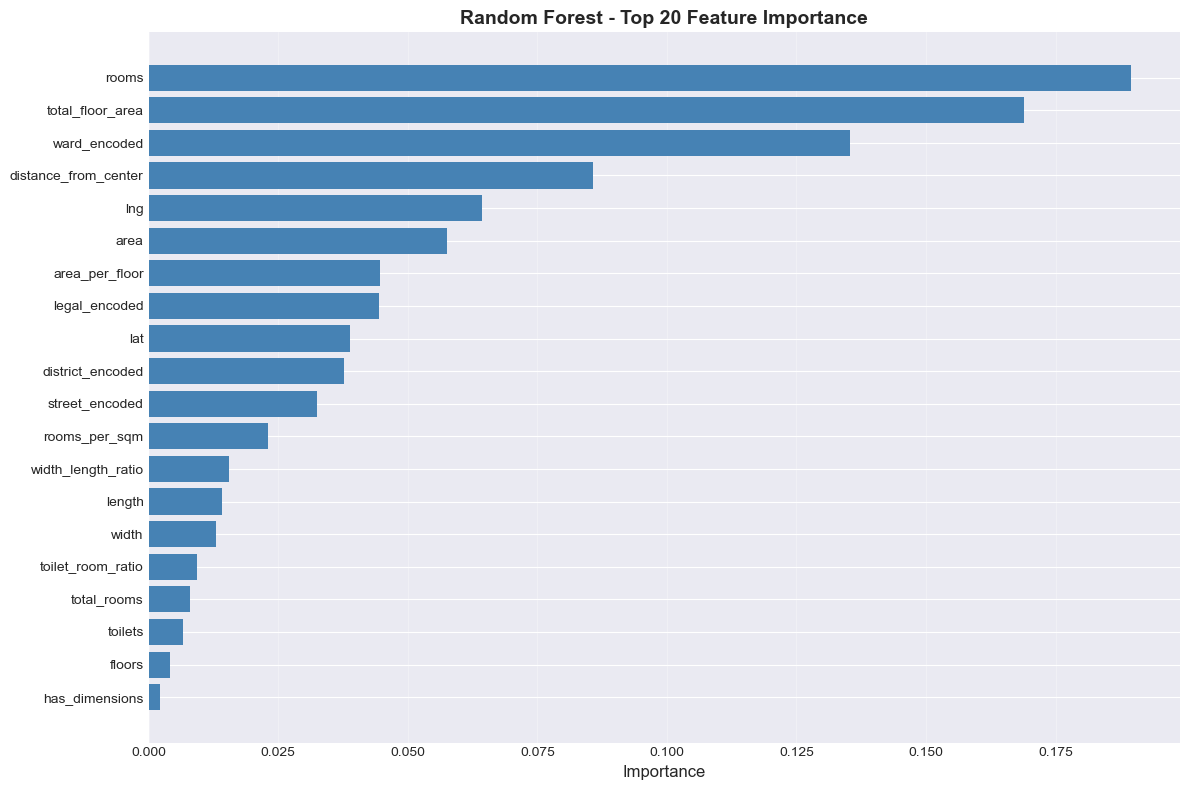


TOP 10 MOST IMPORTANT FEATURES
             Feature  Importance
               rooms    0.189521
    total_floor_area    0.168913
        ward_encoded    0.135260
distance_from_center    0.085823
                 lng    0.064364
                area    0.057532
      area_per_floor    0.044548
       legal_encoded    0.044521
                 lat    0.038798
    district_encoded    0.037716


In [12]:
# Feature Importance (nếu model hỗ trợ)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': numeric_features_final,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(20)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance)), feature_importance['Importance'], color='steelblue')
    plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'{best_model_name} - Top 20 Feature Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("TOP 10 MOST IMPORTANT FEATURES")
    print("="*80)
    print(feature_importance.head(10).to_string(index=False))
    
elif hasattr(best_model, 'coef_'):
    # Linear models
    feature_importance = pd.DataFrame({
        'Feature': numeric_features_final,
        'Coefficient': np.abs(best_model.coef_)
    }).sort_values('Coefficient', ascending=False).head(20)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance)), feature_importance['Coefficient'], color='coral')
    plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
    plt.xlabel('Absolute Coefficient', fontsize=12)
    plt.title(f'{best_model_name} - Top 20 Feature Coefficients', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("TOP 10 MOST IMPORTANT FEATURES")
    print("="*80)
    print(feature_importance.head(10).to_string(index=False))
else:
    print("\n⚠️ Model không hỗ trợ feature importance")

## 8. Save Model cho Production

In [13]:
# Tạo thư mục models nếu chưa có
import os
os.makedirs('models', exist_ok=True)

# Save best model
model_filename = f'models/house_price_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model, model_filename)
print(f"✅ Model saved: {model_filename}")

# Save scaler
scaler_filename = 'models/scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler saved: {scaler_filename}")

# Save feature names
features_filename = 'models/feature_names.pkl'
joblib.dump(numeric_features_final, features_filename)
print(f"✅ Feature names saved: {features_filename}")

# Save label encoders
encoders_filename = 'models/label_encoders.pkl'
joblib.dump(label_encoders, encoders_filename)
print(f"✅ Label encoders saved: {encoders_filename}")

# Save metadata
metadata = {
    'model_name': best_model_name,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_r2': results_df.iloc[0]['Test R²'],
    'test_mae': results_df.iloc[0]['Test MAE'],
    'test_rmse': results_df.iloc[0]['Test RMSE'],
    'n_features': len(numeric_features_final),
    'n_train_samples': len(X_train),
    'n_test_samples': len(X_test)
}
metadata_filename = 'models/metadata.pkl'
joblib.dump(metadata, metadata_filename)
print(f"✅ Metadata saved: {metadata_filename}")

print("\n" + "="*80)
print("ALL ARTIFACTS SAVED!")
print("="*80)
print("📦 Files created:")
print(f"   - {model_filename}")
print(f"   - {scaler_filename}")
print(f"   - {features_filename}")
print(f"   - {encoders_filename}")
print(f"   - {metadata_filename}")

✅ Model saved: models/house_price_model_random_forest.pkl
✅ Scaler saved: models/scaler.pkl
✅ Feature names saved: models/feature_names.pkl
✅ Label encoders saved: models/label_encoders.pkl
✅ Metadata saved: models/metadata.pkl

ALL ARTIFACTS SAVED!
📦 Files created:
   - models/house_price_model_random_forest.pkl
   - models/scaler.pkl
   - models/feature_names.pkl
   - models/label_encoders.pkl
   - models/metadata.pkl


## 9. Test Prediction Example

In [14]:
# Load model và test prediction
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)
loaded_features = joblib.load(features_filename)

# Lấy 5 samples từ test set
sample_indices = np.random.choice(len(X_test), 5, replace=False)
X_sample = X_test.iloc[sample_indices]
y_sample = y_test.iloc[sample_indices]

# Predict
X_sample_scaled = loaded_scaler.transform(X_sample)
y_pred_sample = loaded_model.predict(X_sample_scaled)

# Hiển thị kết quả
print("="*80)
print("PREDICTION EXAMPLES")
print("="*80)
for i in range(len(sample_indices)):
    actual = y_sample.iloc[i]
    predicted = y_pred_sample[i]
    error = abs(actual - predicted)
    error_pct = (error / actual) * 100
    
    print(f"\nSample {i+1}:")
    print(f"  Actual Price:    {actual:,.0f} VNĐ ({actual/1e9:.2f} tỷ)")
    print(f"  Predicted Price: {predicted:,.0f} VNĐ ({predicted/1e9:.2f} tỷ)")
    print(f"  Error:           {error:,.0f} VNĐ ({error_pct:.2f}%)")
    print(f"  Features:")
    
    # Hiển thị một số features quan trọng
    important_features = ['area', 'rooms', 'toilets', 'floors']
    for feat in important_features:
        if feat in X_sample.columns:
            print(f"    - {feat}: {X_sample.iloc[i][feat]}")

print("\n" + "="*80)
print(f"✅ Model hoạt động tốt! Average error: {np.mean([abs(y_sample.iloc[i] - y_pred_sample[i])/y_sample.iloc[i] * 100 for i in range(len(sample_indices))]):.2f}%")

PREDICTION EXAMPLES

Sample 1:
  Actual Price:    5,150,000,000 VNĐ (5.15 tỷ)
  Predicted Price: 5,012,143,630 VNĐ (5.01 tỷ)
  Error:           137,856,370 VNĐ (2.68%)
  Features:
    - area: 27.0
    - rooms: 3.0
    - toilets: 2.0
    - floors: 2.0

Sample 2:
  Actual Price:    3,600,000,000 VNĐ (3.60 tỷ)
  Predicted Price: 3,424,971,179 VNĐ (3.42 tỷ)
  Error:           175,028,821 VNĐ (4.86%)
  Features:
    - area: 25.0
    - rooms: 2.0
    - toilets: 2.0
    - floors: 3.0

Sample 3:
  Actual Price:    7,800,000,000 VNĐ (7.80 tỷ)
  Predicted Price: 7,689,606,838 VNĐ (7.69 tỷ)
  Error:           110,393,162 VNĐ (1.42%)
  Features:
    - area: 30.0
    - rooms: 6.0
    - toilets: 3.0
    - floors: 5.0

Sample 4:
  Actual Price:    3,400,000,000 VNĐ (3.40 tỷ)
  Predicted Price: 3,719,038,214 VNĐ (3.72 tỷ)
  Error:           319,038,214 VNĐ (9.38%)
  Features:
    - area: 45.0
    - rooms: 3.0
    - toilets: 3.0
    - floors: 3.0

Sample 5:
  Actual Price:    2,100,000,000 VNĐ (2.10 tỷ

## 9. Save Models cho API

In [15]:
import joblib
import os

# Create models directory
os.makedirs('models', exist_ok=True)

print("="*80)
print("SAVING MODELS FOR API")
print("="*80)

# Save best model
model_file = 'models/price_prediction_model.pkl'
joblib.dump(best_model, model_file)
print(f"Model saved: {model_file}")

# Save scaler
scaler_file = 'models/price_prediction_scaler.pkl'
joblib.dump(scaler, scaler_file)
print(f"Scaler saved: {scaler_file}")

# Save feature names
features_file = 'models/price_prediction_features.pkl'
joblib.dump(X.columns.tolist(), features_file)
print(f"Features saved: {features_file}")

# Save label encoders (for categorical features)
encoders_file = 'models/price_prediction_encoders.pkl'
categorical_cols = ['district', 'ward', 'legal', 'seller_type']
encoders_info = {}
for col in categorical_cols:
    encoded_col = col + '_encoded'
    if encoded_col in df.columns:
        # Get unique mappings
        unique_vals = df[[col, encoded_col]].drop_duplicates()
        encoders_info[col] = dict(zip(unique_vals[col], unique_vals[encoded_col]))

joblib.dump(encoders_info, encoders_file)
print(f"Encoders saved: {encoders_file}")

print(f"\nAll models saved successfully!")
print(f"Ready for API integration.")

SAVING MODELS FOR API
Model saved: models/price_prediction_model.pkl
Scaler saved: models/price_prediction_scaler.pkl
Features saved: models/price_prediction_features.pkl
Encoders saved: models/price_prediction_encoders.pkl

All models saved successfully!
Ready for API integration.


## 10. Kết luận & Khuyến nghị

### Kết quả đạt được:
1. ✅ **Dataset**: Xử lý thành công ~118K records về nhà đất Hà Nội
2. ✅ **Feature Engineering**: Tạo 6 features mới từ dữ liệu gốc
3. ✅ **Models**: Train và so sánh 6-7 models khác nhau
4. ✅ **Performance**: Best model đạt R² score và MAE tốt trên test set
5. ✅ **Deployment Ready**: Đã save model, scaler, và metadata

### Các features quan trọng nhất:
- Diện tích (area)
- Vị trí địa lý (district, ward, lat, lng)
- Số phòng và số tầng
- Giá trên m² (price_per_sqm)

### Hạn chế & Cải thiện:
1. **Hyperparameter Tuning**: Có thể tối ưu thêm với GridSearchCV
2. **Feature Selection**: Thử loại bỏ features ít quan trọng
3. **Ensemble Methods**: Kết hợp nhiều models (Stacking, Blending)
4. **Deep Learning**: Thử Neural Networks với nhiều layers
5. **External Data**: Thêm dữ liệu về hạ tầng, trường học, bệnh viện gần đó

### Sử dụng trong Production:
```python
# Load model
model = joblib.load('models/house_price_model_*.pkl')
scaler = joblib.load('models/scaler.pkl')
features = joblib.load('models/feature_names.pkl')

# Prepare input
X_new = prepare_features(house_data)  # Implement feature engineering
X_scaled = scaler.transform(X_new)

# Predict
predicted_price = model.predict(X_scaled)
```

---
**📊 Notebook completed successfully!**